# Using NetworkX for connectivity metrics



In [1]:
%%capture
# Install dotmotif with one line.
# On your own computer, you can run this in the terminal.
!pip3 install dotmotif networkx
import numpy as np
import networkx as nx
from dotmotif import Motif, GrandIsoExecutor
import pandas
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from scipy.stats import ranksums
import statsmodels.stats.multitest as smm



In [46]:
pip install standard_transform

  Preparing metadata (setup.py) ... done
  Created wheel for standard_transform: filename=standard_transform-1.4.0-py3-none-any.whl size=22356 sha256=f0f79e205ad2104a490cf2619f043d35ac08f0e756d3a603458ed4f91d072075
  Stored in directory: /root/.cache/pip/wheels/5c/b4/b0/88383fc6f3996887978623e07e0eee95ffedf1afbbc2872da4
Successfully built standard_transform


In [ ]:
pip install caveclient

In [2]:
import sys 
sys.path.append("C://Users//saika//Downloads")

In [3]:

import v1dd_coregistration_wrangling

In [4]:
def calc_ground_truth(pre_cells, synapse, post_cells, use_sizes=False):
    pre_cell_pt_index = pre_cells['pt_root_id']
    post_cell_pt_index = post_cells['pt_root_id']
    synapses = synapse[(synapse['pre_pt_root_id'].isin(pre_cells['pt_root_id'])) & (synapse['post_pt_root_id'].isin(post_cells['pt_root_id']))]
    pre_cell_pt_index = pre_cell_pt_index.to_list()
    post_cell_pt_index = post_cell_pt_index.to_list()

    synapse_connectome = np.zeros((len(pre_cells), len(post_cells)))
    for synapse in tqdm(range(len(synapses))):
        preidx = pre_cell_pt_index.index(synapses.iloc[synapse]['pre_pt_root_id'])
        postidx = post_cell_pt_index.index(synapses.iloc[synapse]['post_pt_root_id'])
        if use_sizes:
            synapse_connectome[preidx,postidx] += synapses.iloc[synapse]['size']
        else:
            synapse_connectome[preidx,postidx] += 1
    return synapse_connectome

In [9]:
pip install --upgrade fsspec

     -------------------------------------- 316.1/316.1 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2022.7.1
    Uninstalling fsspec-2022.7.1:
      Successfully uninstalled fsspec-2022.7.1
Note: you may need to restart the kernel to use updated packages.


In [6]:
tables, mappings = v1dd_coregistration_wrangling.get_tables_and_mappings(online=True)

In [7]:


# Full Matrix
# weight_matrix = np.load('ground_truth_summed_weights_v1dd_668.npy')
# adjacency_matrix = weight_matrix.clip(0,1)
# graph = nx.from_numpy_array(adjacency_matrix, create_using=nx.DiGraph)

#tables, mappings = v1dd_coregistration_wrangling.get_tables_and_mappings(online=True)

# Make a graph of just excitatory cells
cell_table_original = tables['cell']

# # cell_table = cell_table.query('soma_layer == "23"')[['pt_root_id', 'soma_layer']].reset_index()
cell_table_original['connectome_index'] = cell_table_original.index

cell_table = cell_table_original     #.query('soma_layer == "23"')[['connectome_index', 'pt_root_id', 'soma_layer']].reset_index()
# cell_table['connectome_index'] = cell_table.index
# cell_table = cell_table.query('cell_type == "PYC"')[['connectome_index', 'pt_root_id', 'soma_layer']].reset_index()

synapse_table = pandas.read_feather('C://Users//saika//Downloads//v1dd_with_additional_coregistered_neurons_Julian_latest_now//v1dd_with_additional_coregistered_neurons_Julian_latest//additional_coregistered_neurons//synapse_table_v1dd_shortened_additional_cells.feather')
weight_matrix = calc_ground_truth(cell_table, synapse_table, cell_table, use_sizes=True)
adjacency_matrix = weight_matrix.clip(0,1)
pyr_graph = nx.from_numpy_array(adjacency_matrix, create_using=nx.DiGraph)

100%|██████████| 159090/159090 [04:42<00:00, 563.90it/s]


In [8]:
print(adjacency_matrix.shape)

(712, 712)


In [9]:
len(synapse_table)

197718

In [10]:
cell_table

,index,pt_root_id,target_id,cell_type,pt_position,soma_layer,full_connectome_index,connectome_index
0,3,864691132625300120,293764,PYC,"[882.3273740159214, 348.2992615823263, 49.7502...",4,0,0
1,19,864691132710501931,295576,BC,"[846.1511939783203, 407.8189411938162, 116.071...",5,1,1
2,27,864691132830575876,278405,MC,"[741.1664982372881, 269.52172688591605, 122.27...",23,2,2
3,34,864691132616354625,293733,BPC,"[862.543768852058, 349.23141366917696, 44.0541...",4,3,3
4,37,864691132999200949,307952,PYC,"[872.0169357283554, 490.6735632622339, 28.3308...",5,4,4
...,...,...,...,...,...,...,...,...
707,3750,864691132690984696,352177,BC,"[911.9532185557016, 266.8306003665616, 76.2196...",23,707,707
708,3754,864691132679146333,385115,PYC,"[979.9463704043851, 534.8907307114326, 152.600...",5,708,708
709,3757,864691132579592205,351167,BC,"[930.7398299477137, 190.36452769244295, 38.169...",23,709,709
710,3759,864691132763271347,383491,PYC,"[933.106127419254, 463.0370044502767, 91.12912...",5,710,710


#**NETWORKX METRICS CHECK**

In [11]:
# Calculate metrics
CC = nx.average_clustering(pyr_graph)  # clustering coefficient

L = nx.average_shortest_path_length(pyr_graph)  # Average shortest path length

# Generate a random graph with the same number of nodes and edges
G_rand = nx.gnm_random_graph(pyr_graph.number_of_nodes(), pyr_graph.number_of_edges(), directed=True)

# Calculate random metrics
CC_rand = nx.average_clustering(G_rand)  # Random clustering coefficient
L_rand = nx.average_shortest_path_length(G_rand.to_directed())  # Random average shortest path length

# Calculate small-worldness
sigma = (CC / CC_rand) * (L_rand / L)


# Print results
print("Out-degree Clustering Coefficient (CC_out):", CC)
#print("In-degree Clustering Coefficient (CC_in):", CC_in)
print("Average Shortest Path Length (L):", L)
print("Random Clustering Coefficient (CC_rand):", CC_rand)
print("Random Average Shortest Path Length (L_rand):", L_rand)
print("Small-Worldness (σ):", sigma)

NetworkXError: Graph is not strongly connected.

#CENTRALITY: 
Degree centrality, in-degree centrality, out-degree centrality, closeness centrality

In [12]:
centrality = nx.degree_centrality(pyr_graph)
indegree_centrality = nx.in_degree_centrality(pyr_graph)
outdegree_centrality = nx.out_degree_centrality(pyr_graph)
closeness_centrality = nx.closeness_centrality(pyr_graph)

In [13]:
cell_table['centrality'] = centrality
cell_table['indegree_centrality'] = indegree_centrality
cell_table['outdegree_centrality'] = outdegree_centrality
cell_table['closeness_centrality'] = closeness_centrality

In [14]:
assemblies_by_connectome_index = tables['assemblies_by_connectome_index']    #Assembly number for the cell in the connectome

In [15]:
assemblies_by_connectome_index

{310: ['A 1'],
 679: ['A 1', 'A 3', 'A 4', 'A 7'],
 246: ['A 1', 'A 3', 'A 4', 'A 5', 'A 7', 'A 8'],
 8: ['A 1'],
 517: ['A 1', 'A 5', 'A 7', 'A 10'],
 374: ['A 1', 'A 3'],
 101: ['A 1'],
 615: ['A 1', 'A 4', 'A 7', 'A 8'],
 133: ['A 1', 'A 4', 'A 7', 'A 8'],
 180: ['A 1', 'A 2', 'A 8'],
 448: ['A 1', 'A 3'],
 575: ['A 1'],
 352: ['A 1', 'A 3', 'A 5'],
 546: ['A 1', 'A 2', 'A 3'],
 288: ['A 1', 'A 6'],
 347: ['A 1'],
 100: ['A 1', 'A 4'],
 163: ['A 1', 'A 6'],
 23: ['A 1', 'A 3', 'A 4'],
 698: ['A 1', 'A 2'],
 266: ['A 1', 'A 6'],
 627: ['A 1', 'A 3', 'A 8'],
 671: ['A 2'],
 56: ['A 2', 'A 11'],
 90: ['A 2'],
 372: ['A 2'],
 598: ['A 2', 'A 10'],
 664: ['A 2', 'A 4', 'A 5'],
 318: ['A 2', 'A 10'],
 250: ['A 3'],
 184: ['A 3', 'A 7', 'A 8'],
 43: ['A 4'],
 543: ['A 4'],
 670: ['A 4', 'A 5', 'A 7', 'A 8'],
 132: ['A 4', 'A 5', 'A 7', 'A 8'],
 587: ['A 5', 'A 7'],
 706: ['A 6'],
 468: ['A 9', 'A 12'],
 519: ['A 9'],
 596: ['A 10'],
 242: ['A 14'],
 494: ['No A'],
 205: ['No A'],
 630: ['N

In [16]:
def get_indices_and_assemblies(assemblies_by_connectome_index):
   cells_index = []    #connectome index of cell
   assembly_id = []    #assembly id

   for cell in assemblies_by_connectome_index:
      cells_index.append(cell)

   for assembly in assemblies_by_connectome_index.values():
      assembly_id.append(assembly)
   '''for assembly in cell_indices_by_assemblies:
       for cell in cell_indices_by_assemblies[assembly]:
        cells_index.append(cell)
        assembly_id.append(assembly)'''

   return cells_index, assembly_id



In [17]:

cell_idx, assembly_id = get_indices_and_assemblies(assemblies_by_connectome_index)

#sort the indices and assembly id - make a new dataframe
cell_index_and_assembly = pandas.DataFrame()
cell_index_and_assembly['cell_index'] = cell_idx
cell_index_and_assembly['assembly_id'] = assembly_id

In [18]:
cell_index_and_assembly


,cell_index,assembly_id
0,310,[A 1]
1,679,"[A 1, A 3, A 4, A 7]"
2,246,"[A 1, A 3, A 4, A 5, A 7, A 8]"
3,8,[A 1]
4,517,"[A 1, A 5, A 7, A 10]"
5,374,"[A 1, A 3]"
6,101,[A 1]
7,615,"[A 1, A 4, A 7, A 8]"
8,133,"[A 1, A 4, A 7, A 8]"
9,180,"[A 1, A 2, A 8]"


In [ ]:
#cell_index_and_assembly = cell_index_and_assembly.groupby('cell_index')['assembly_id'].apply(list).reset_index()

In [19]:

def get_assemblyIndex_for_Connectome_cells(cell_table, cell_index_and_assembly):
 connectome_assembly_id = []   #assembly id for all the cells in a connectome
 #non_assembly_cell_in_connectome = []
 #assembly_cell_not_in_connectome = []
 assembly_cell=[]   #a cell that is present in an assembly-------derived from assemblies by connectome index
 for i in range(len(cell_table)):
     connectome_assembly_id.append([])      
 assembly_id_for_cells_in_assemblies = []
 cells_in_assemblies = []   #connectome cells that belong to an assembly
 for cellIndex, assemblyMembershiplist in zip(cell_index_and_assembly['cell_index'],cell_index_and_assembly['assembly_id']):
  for index, cell in enumerate(cell_table['connectome_index']):
    if cellIndex == cell:
      connectome_assembly_id[index] = assemblyMembershiplist      #add the assembly id to the empty list at that connectome index
      assembly_id_for_cells_in_assemblies.append(assemblyMembershiplist)     #this should be equal to cell_index_and_assembly['assembly_id'] 
      cells_in_assemblies.append(cell)   #this should be equal to cell_index_and_assembly['cell_index'] ---- value from cell_table
      assembly_cell.append(cellIndex)    #should match with cells_in_assemblies---- value from 'table'
   # elif cellIndex != cell:
    #  non_assembly_cell_in_connectome.append(cellIndex)
     # assembly_cell_not_in_connectome.append(assemblyIndex)
 return(connectome_assembly_id, assembly_id_for_cells_in_assemblies, cells_in_assemblies, assembly_cell)


In [20]:
connectome_assembly_id, assembly_id_for_cells_in_assemblies, cells_in_assemblies, assembly_cell = get_assemblyIndex_for_Connectome_cells(cell_table, cell_index_and_assembly)



In [21]:
cell_table['assembly_id'] = connectome_assembly_id #add assembly id for each cell in the connectome to the main cell table


In [22]:
cell_table #[check]

,index,pt_root_id,target_id,cell_type,pt_position,soma_layer,full_connectome_index,connectome_index,centrality,indegree_centrality,outdegree_centrality,closeness_centrality,assembly_id
0,3,864691132625300120,293764,PYC,"[882.3273740159214, 348.2992615823263, 49.7502...",4,0,0,0.073136,0.046414,0.026723,0.413166,[]
1,19,864691132710501931,295576,BC,"[846.1511939783203, 407.8189411938162, 116.071...",5,1,1,0.070323,0.040788,0.029536,0.426343,[]
2,27,864691132830575876,278405,MC,"[741.1664982372881, 269.52172688591605, 122.27...",23,2,2,0.306610,0.143460,0.163150,0.448933,[]
3,34,864691132616354625,293733,BPC,"[862.543768852058, 349.23141366917696, 44.0541...",4,3,3,0.168776,0.095640,0.073136,0.465251,[]
4,37,864691132999200949,307952,PYC,"[872.0169357283554, 490.6735632622339, 28.3308...",5,4,4,0.075949,0.043601,0.032349,0.432784,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,3750,864691132690984696,352177,BC,"[911.9532185557016, 266.8306003665616, 76.2196...",23,707,707,0.476793,0.174402,0.302391,0.474424,[]
708,3754,864691132679146333,385115,PYC,"[979.9463704043851, 534.8907307114326, 152.600...",5,708,708,0.042194,0.021097,0.021097,0.377870,[]
709,3757,864691132579592205,351167,BC,"[930.7398299477137, 190.36452769244295, 38.169...",23,709,709,0.365682,0.150492,0.215190,0.462035,[]
710,3759,864691132763271347,383491,PYC,"[933.106127419254, 463.0370044502767, 91.12912...",5,710,710,0.084388,0.054852,0.029536,0.441681,[]


In [174]:
''''for cell, index in zip(cell_index_and_assembly['cell_index'], cell_index_and_assembly['assembly_id']):
    if cell not in cells_in_assemblies: #all connectome cells in assemblies:
        print(cell) # all cells in assemblies not in the connectime 
        print(index)

In [23]:
len(assembly_id_for_cells_in_assemblies)

51

36 out of the 51 assembly cells are layer 23? (in the connectome)
=> all connectome cells are typed and proof-read

=> so, all are not co-registered, only the co-registered ones will be there in the cells_in_assemblies

In [86]:
#TRIAL CHECK FOR 'AND' 'OR' LOGIC
''''cells = ['A 1', 'A 1', 'A 1', 'A 1','0']

for idx in cells:
    print(idx != 'A 1')
    print(idx != '0')
    print(idx != 'A 1' or idx != '0')
    print(idx != 'A 1' and idx != '0')


False
True
True
False
False
True
True
False
False
True
True
False
False
True
True
False
True
False
True
False


This shows that OR will always be TRUE!

In [24]:
#plots

#----------DEGREE CENTRALITY------------------------
centrality_assembly_cells = []
centrality_non_assembly_cells = []
idx_check_non_assembly = []

for idx, cent in zip(cell_table['assembly_id'], cell_table['centrality']):
  if idx != ['No A']:    
   print(idx)
   #print(idx)
   centrality_assembly_cells.append(cent)
  else:
    #print(idx)
    #print(cent)
    idx_check_non_assembly.append(idx)
    centrality_non_assembly_cells.append(cent)



[]
[]
[]
[]
[]
[]
[]
[]
['A 1']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['A 1', 'A 3', 'A 4']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['A 4']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['A 2', 'A 11']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['A 2']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['A 1', 'A 4']
['A 1']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['A 4', 'A 5', 'A 7', 'A 8']
['A 1', 'A 4', 'A 7', 'A 8']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['A 1', 'A 6']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['A 1', 'A 2', 'A 8']
[]
[]
[]
['A 3', 'A 7', 'A 8']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['A 14']
[]
[]
[]
['A 1', 'A 3', 'A 4', 'A 5', 'A 7', 'A 8']
[]
[]
[]
['A 3']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


In [25]:
for i in idx_check_non_assembly:
    if i == ['No A']:
        print(i)

['No A']
['No A']
['No A']
['No A']
['No A']
['No A']
['No A']
['No A']
['No A']
['No A']


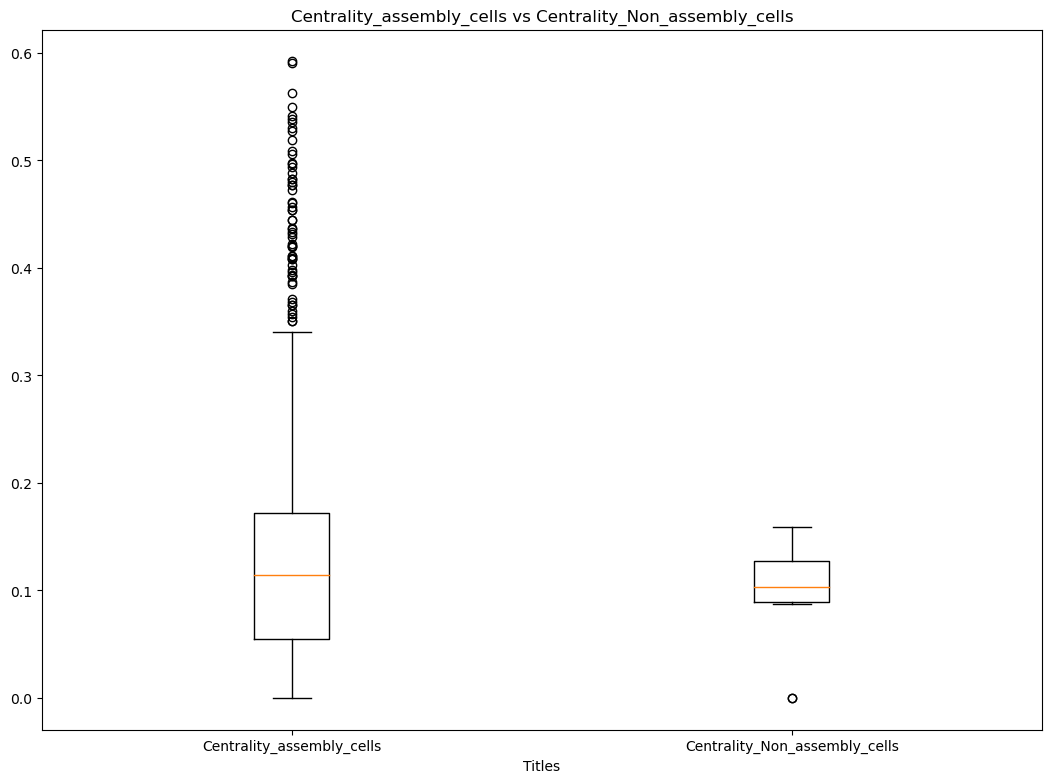

In [26]:
import matplotlib.pyplot as plt

data = [centrality_assembly_cells, centrality_non_assembly_cells]

titles = ['Centrality_assembly_cells', 'Centrality_Non_assembly_cells']

fig = plt.figure(figsize =(10, 7))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.boxplot(data)

# show plot
ax.set_xticklabels(titles)

# Set the x-axis label
plt.xlabel('Titles')
plt.title(f'{titles[0]} vs {titles[1]}')
plt.show()

In [27]:
#---------------------------------plots for in-degree------------------------------------

indegree_centrality_assembly_cells = []
indegree_centrality_non_assembly_cells = []
idx_check_non_assembly = []

for idx, in_cent in zip(cell_table['assembly_id'], cell_table['indegree_centrality']):
  if  idx != ['No A']:    
   #print(idx)
   #print(idx)
   indegree_centrality_assembly_cells.append(in_cent)
  else:
    #print(idx)
    #print(cent)
    idx_check_non_assembly.append(idx)
    indegree_centrality_non_assembly_cells.append(in_cent)

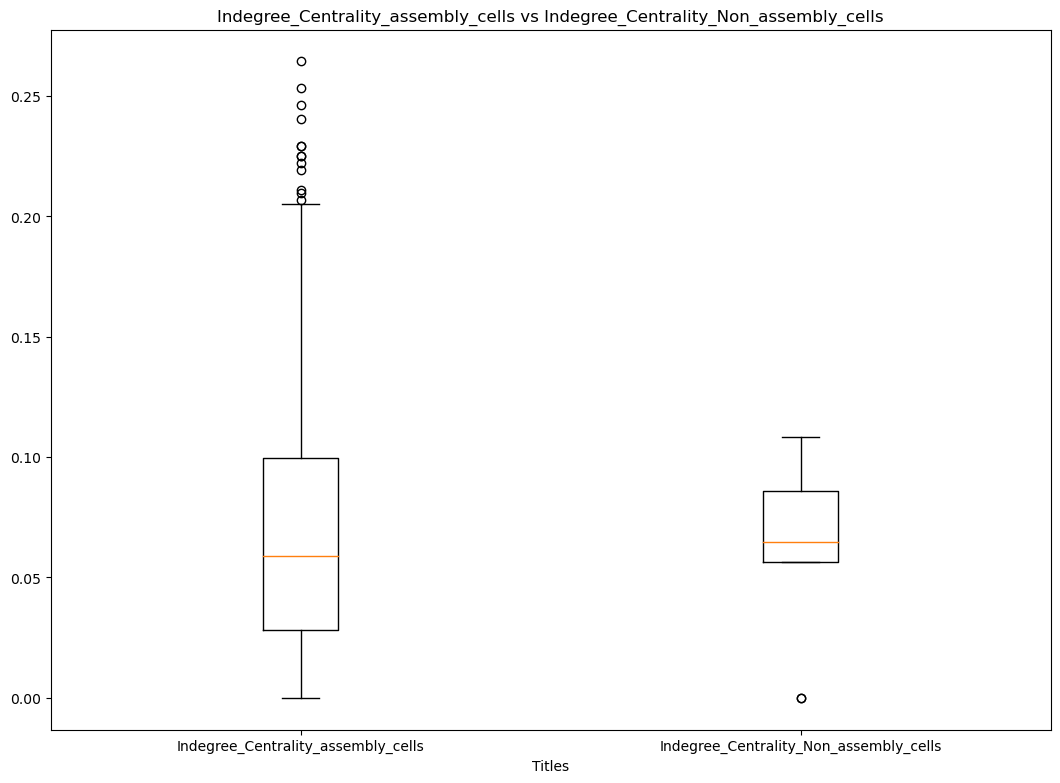

In [28]:
data = [indegree_centrality_assembly_cells, indegree_centrality_non_assembly_cells]

titles = ['Indegree_Centrality_assembly_cells', 'Indegree_Centrality_Non_assembly_cells']

fig = plt.figure(figsize =(10, 7))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.boxplot(data)

# show plot
ax.set_xticklabels(titles)

# Set the x-axis label
plt.xlabel('Titles')
plt.title(f'{titles[0]} vs {titles[1]}')
plt.show()

In [29]:
#Ranksums test

from scipy.stats import ranksums

stat = ranksums(indegree_centrality_assembly_cells, indegree_centrality_non_assembly_cells)
stat.pvalue

0.954314164694236

In [30]:
#---------------------plots for out-degree---------------------------------

outdegree_centrality_assembly_cells = []
outdegree_centrality_non_assembly_cells = []
idx_check_non_assembly = []

for idx, out_cent in zip(cell_table['assembly_id'], cell_table['outdegree_centrality']):
  if idx != ['No A']:    
   #print(idx)
   #print(idx)
   outdegree_centrality_assembly_cells.append(out_cent)
  else:
    #print(idx)
    #print(cent)
    idx_check_non_assembly.append(idx)
    outdegree_centrality_non_assembly_cells.append(out_cent)

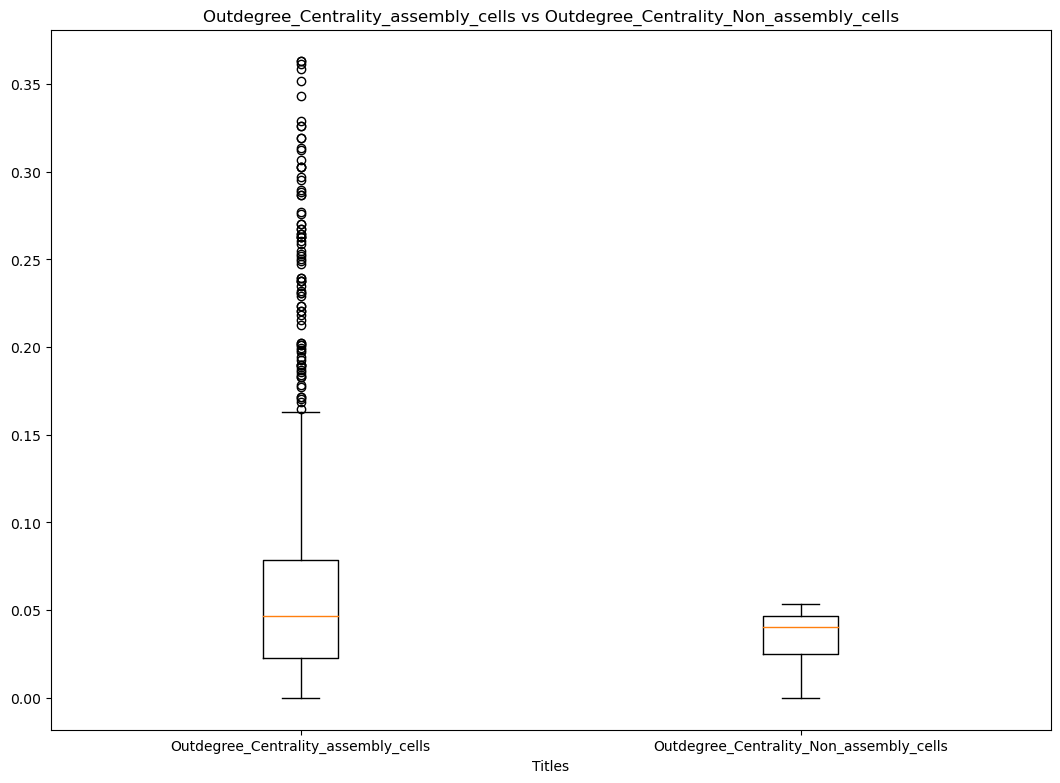

In [31]:
data = [outdegree_centrality_assembly_cells, outdegree_centrality_non_assembly_cells]

titles = ['Outdegree_Centrality_assembly_cells', 'Outdegree_Centrality_Non_assembly_cells']

fig = plt.figure(figsize =(10, 7))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.boxplot(data)

# show plot
ax.set_xticklabels(titles)

# Set the x-axis label
plt.xlabel('Titles')
plt.title(f'{titles[0]} vs {titles[1]}')
plt.show()

In [32]:
#statistical test
stat = ranksums(outdegree_centrality_assembly_cells, outdegree_centrality_non_assembly_cells)
stat.pvalue

0.13757149189144993

In [33]:
closeness_centrality_assembly_cells = []
closeness_centrality_non_assembly_cells = []
idx_check_non_assembly = []

for idx, close_cent in zip(cell_table['assembly_id'], cell_table['closeness_centrality']):
  if idx != ['No A']:    
   #print(idx)
   #print(idx)
   closeness_centrality_assembly_cells.append(close_cent)
  else:
    #print(idx)
    #print(cent)
    idx_check_non_assembly.append(idx)
    closeness_centrality_non_assembly_cells.append(close_cent)

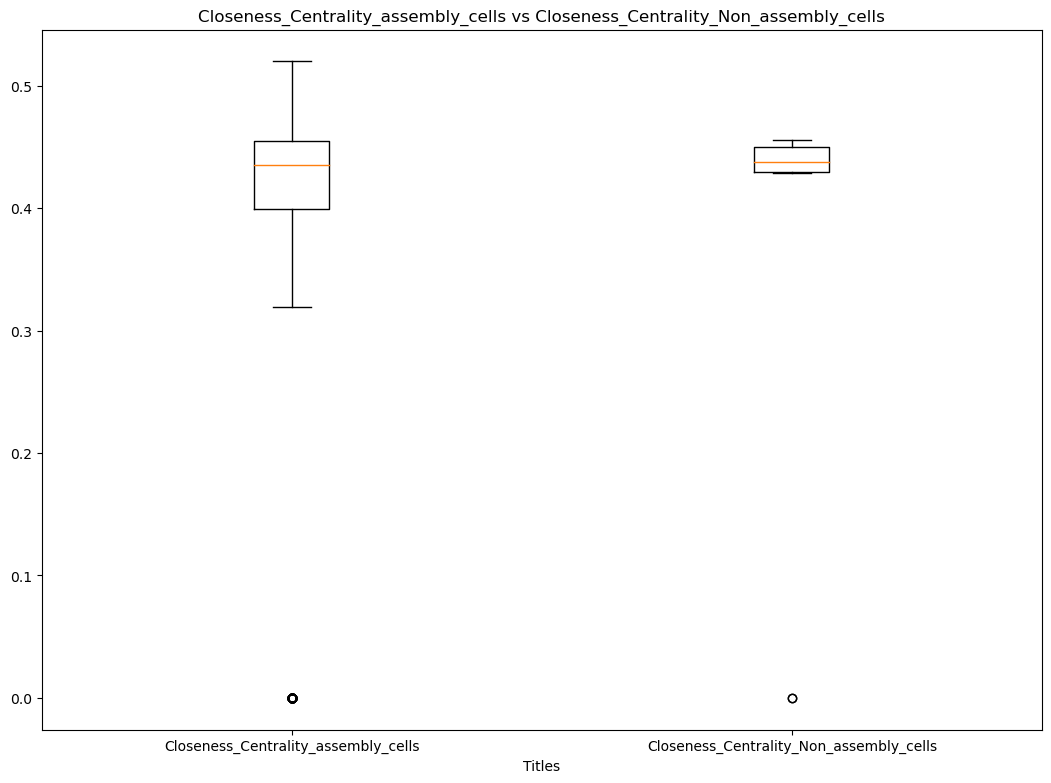

In [34]:
#-----------------------------plot for closeness centrality ----------------------------------
data = [closeness_centrality_assembly_cells, closeness_centrality_non_assembly_cells]

titles = ['Closeness_Centrality_assembly_cells', 'Closeness_Centrality_Non_assembly_cells']

fig = plt.figure(figsize =(10, 7))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.boxplot(data)

# show plot
ax.set_xticklabels(titles)

# Set the x-axis label
plt.xlabel('Titles')
plt.title(f'{titles[0]} vs {titles[1]}')
plt.show()

In [35]:
#stat test
stat = ranksums(closeness_centrality_assembly_cells, closeness_centrality_non_assembly_cells)
stat.pvalue

0.9026440494938841